In [1]:
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os
from matplotlib import pyplot as plt

## Loading Face Detector

In [2]:
facedetector_path = "../face_detection_model/"

In [3]:
proto_path = facedetector_path+"deploy.prototxt"
model_path = facedetector_path+"res10_300x300_ssd_iter_140000.caffemodel"

In [4]:
detector = cv2.dnn.readNetFromCaffe(proto_path, model_path)

## Load Face Embedding Model

In [5]:
embedding_model_path = facedetector_path+"/openface_nn4.small2.v1.t7"

In [6]:
embedder = cv2.dnn.readNetFromTorch(embedding_model_path)

## Load Recognizer

In [7]:
recognizer_model_path = "../output/recognizer.pickle"
le_model_path = "../output/le.pickle"

In [8]:
recognizer = pickle.loads(open(recognizer_model_path, "rb").read())
le = pickle.loads(open(le_model_path, "rb").read())

## Image

In [10]:
image = cv2.imread("../dataset/Abdul Kalam/apjabdul-kalam-best-hd-photos-1080p-2km.jpg")
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]

In [11]:
# construct a blob from the image
imageBlob = cv2.dnn.blobFromImage(
	cv2.resize(image, (300, 300)), 1.0, (300, 300),
	(104.0, 177.0, 123.0), swapRB=False, crop=False)

In [12]:
# apply OpenCV's deep learning-based face detector to localize
# faces in the input image
detector.setInput(imageBlob)
detections = detector.forward()


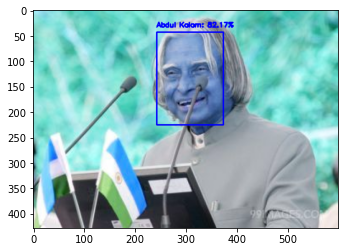

In [13]:
# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with the
	# prediction
	confidence = detections[0, 0, i, 2]

	# filter out weak detections
	if confidence >0.5:
		# compute the (x, y)-coordinates of the bounding box for the
		# face
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# extract the face ROI
		face = image[startY:endY, startX:endX]
		(fH, fW) = face.shape[:2]

		# ensure the face width and height are sufficiently large
		if fW < 20 or fH < 20:
			continue

		# construct a blob for the face ROI, then pass the blob
		# through our face embedding model to obtain the 128-d
		# quantification of the face
		faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96),
			(0, 0, 0), swapRB=True, crop=False)
		embedder.setInput(faceBlob)
		vec = embedder.forward()

		# perform classification to recognize the face
		preds = recognizer.predict_proba(vec)[0]
		j = np.argmax(preds)
		proba = preds[j]
		name = le.classes_[j]

		# draw the bounding box of the face along with the associated
		# probability
		text = "{}: {:.2f}%".format(name, proba * 100)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY),
			(0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

# show the output image
plt.imshow(image)